# Exploratory analysis of options strategies

In [1]:
%config InlineBackend.figure_format = "retina"

import numpy as np
import pandas as pd
import warnings
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
import seaborn as sns

warnings.simplefilter("ignore")
register_matplotlib_converters()
sns.set()

We are interested in the relation of volatility, as measured by the VIX, with different options strategies.  
VIX data provided by [CBOE](http://www.cboe.com/products/vix-index-volatility/vix-options-and-futures/vix-index/vix-historical-data).  
More information on the VIX index found [here](https://www.investopedia.com/articles/active-trading/070213/tracking-volatility-how-vix-calculated.asp).

In [13]:
# VIX data 1990-2003
vix_archive = pd.read_excel("../data/vixarchive.xls", skiprows=[0], parse_dates=["Date"], index_col="Date")
vix_archive.head()

,VIX Open,VIX High,VIX Low,VIX Close
Date,,,,
1990-01-02,NaN,NaN,NaN,17.24
1990-01-03,NaN,NaN,NaN,18.19
1990-01-04,NaN,NaN,NaN,19.22
1990-01-05,NaN,NaN,NaN,20.11
1990-01-08,NaN,NaN,NaN,20.26


In [14]:
len(vix_archive)

3532

In [15]:
# VIX data 2004-present
vix_current = pd.read_csv("../data/vixcurrent.csv", skiprows=1, parse_dates=["Date"], index_col="Date")
vix_current.head()

,VIX Open,VIX High,VIX Low,VIX Close
Date,,,,
2004-01-02,17.96,18.68,17.54,18.22
2004-01-05,18.45,18.49,17.44,17.49
2004-01-06,17.66,17.67,16.19,16.73
2004-01-07,16.72,16.75,15.50,15.50
2004-01-08,15.42,15.68,15.32,15.61


In [16]:
len(vix_current)

3825

In [17]:
vix_data = pd.concat([vix_archive, vix_current])
assert len(vix_data) == len(vix_archive) + len(vix_current)

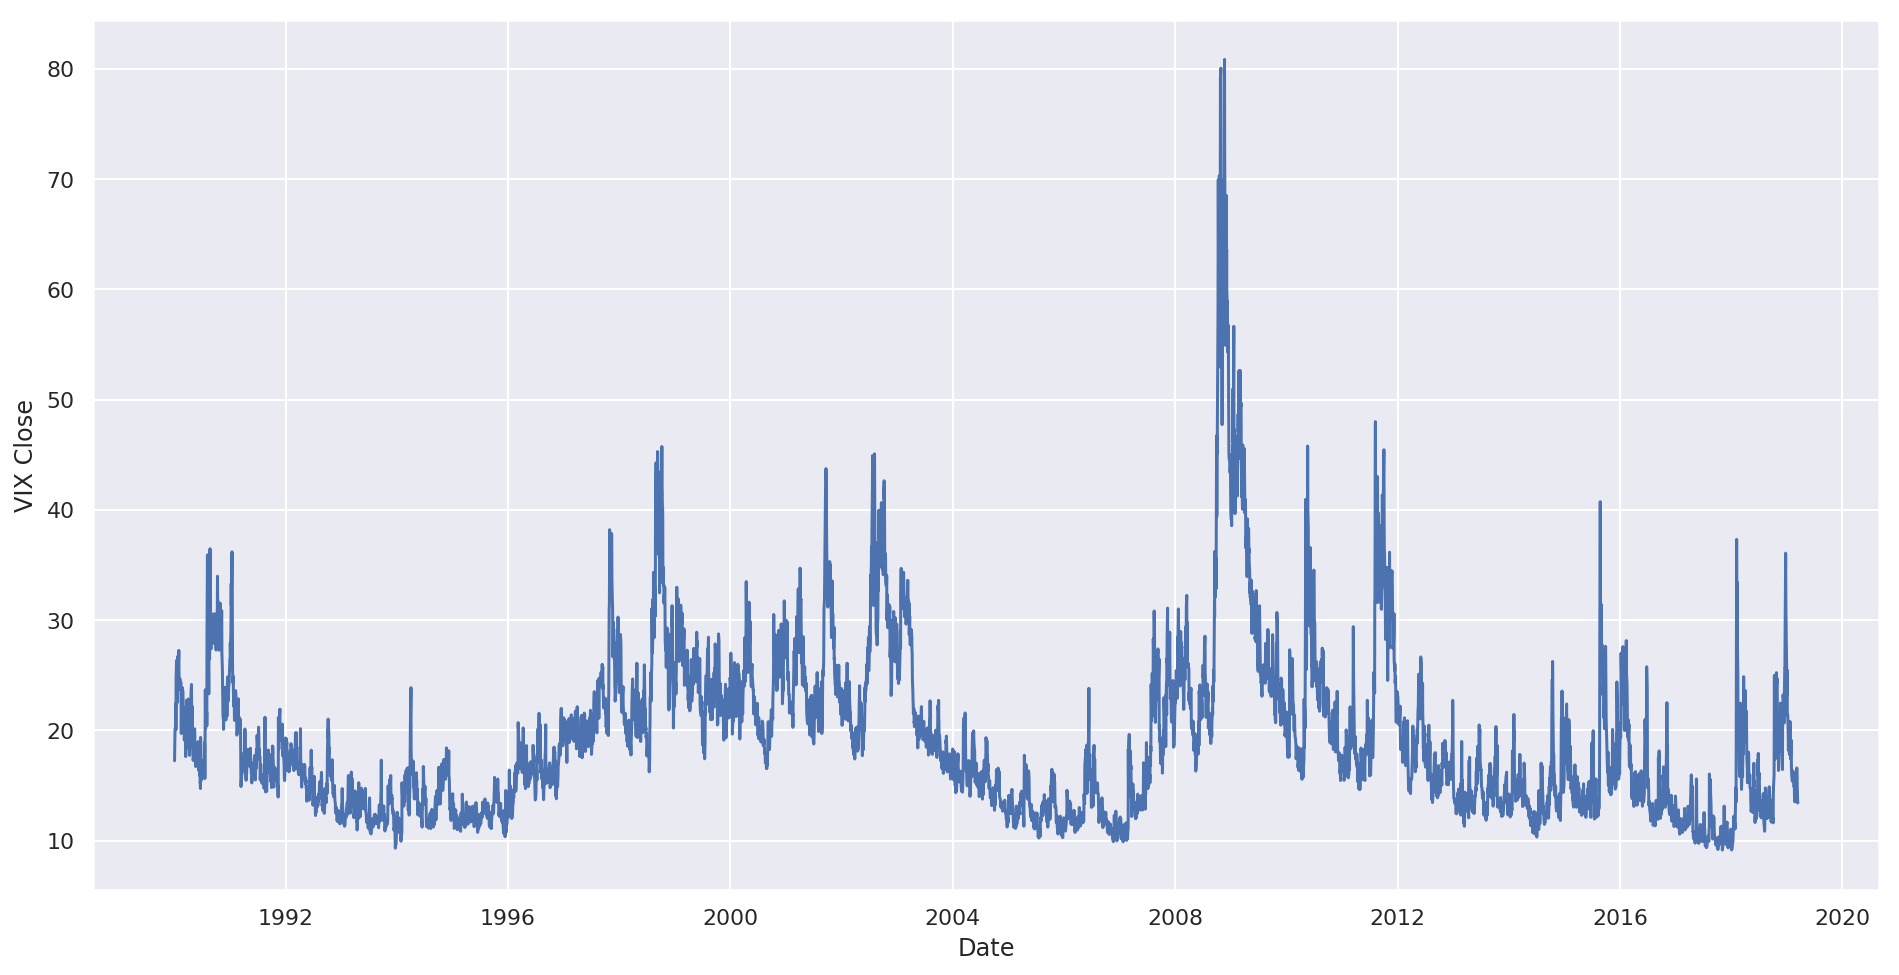

In [18]:
_fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(x=vix_data.index, y="VIX Close", data=vix_data, ax=ax)

In [19]:
vix_data.to_csv("../data/vix_data.csv")

We will test out the strategy on the SPX options data from 2010.

In [20]:
spx_data = pd.read_csv("../data/allspx/SPX_2010.csv", parse_dates=["quotedate", "expiration"])
spx_data.head()

,underlying,underlying_last,exchange,optionroot,optionext,type,expiration,quotedate,strike,last,bid,ask,volume,openinterest,impliedvol,delta,gamma,theta,vega,optionalias
0,SPX,1132.99,W,JXB100108C00925000,NaN,call,2010-01-08,2010-01-04,925,0.0,205.8,208.8,0,0,0.2284,0.9997,0.0,35.6003,0.0000,JXB100108C00925000
1,SPX,1132.99,W,JXB100108C00950000,NaN,call,2010-01-08,2010-01-04,950,0.0,180.9,183.9,0,0,0.2284,0.9997,0.0,35.5378,0.0000,JXB100108C00950000
2,SPX,1132.99,W,JXB100108C00975000,NaN,call,2010-01-08,2010-01-04,975,0.0,155.9,158.9,0,0,0.2284,0.9997,0.0,35.4753,0.0000,JXB100108C00975000
3,SPX,1132.99,W,JXB100108C01000000,NaN,call,2010-01-08,2010-01-04,1000,0.0,130.9,133.9,0,0,0.2284,0.9997,0.0,35.4127,0.0000,JXB100108C01000000
4,SPX,1132.99,W,JXB100108C01025000,NaN,call,2010-01-08,2010-01-04,1025,0.0,106.0,109.0,0,0,0.2284,0.9997,0.0,35.3356,0.0012,JXB100108C01025000


## Straddle

A (long) straddle is an options strategy that combines a long call and a long put with a strike close to the underlying price. The investor is expecting an increase in volatility, which would make one of the legs profitable.  
The strategy has bounded risk (the total cost of the options) and unbounded profit potential.  
More information [here](https://www.investopedia.com/terms/s/straddle.asp).


We will implement a function to execute the strategy that takes the following parameters:

- `entry_dte`: Number of days to expiration to enter strategy
- `exit_dte`: Number of days to expiration to exit unconditionally
- `tolerance`: Margin of tolerance to determine when the strategy executes
- `qty`: Position size (number of calls and puts to buy)


In [23]:
from math import floor


def dte_filter(data, dte, tolerance=0):
    upper_bound = pd.Timedelta(days=floor(dte + dte * tolerance))
    lower_bound = pd.Timedelta(days=floor(dte - dte * tolerance))
    return data[(data["expiration"] <= data["quotedate"] + upper_bound) &
                (data["expiration"] >= data["quotedate"] + lower_bound)]

def exit_price(option, data):
    if option in data["optionroot"].array:
        return data[data["optionroot"] == option]["bid"].iloc[0]
    else:
        return 0.0

In [30]:
def straddle(data, entry_dte=36, exit_dte=2, tolerance=0.1, qty=10):
    calls = data[data["type"] == "call"]
    call_candidates = dte_filter(calls, entry_dte, tolerance)
    call_candidates["difference"] = np.abs(
        (call_candidates["strike"] - call_candidates["underlying_last"]))
    idx_calls = call_candidates.groupby(["quotedate"])["difference"].idxmin()
    straddle_call_enter = call_candidates.loc[idx_calls, ]
    call_exits = calls[calls["optionroot"].isin(
        straddle_call_enter["optionroot"])]
    straddle_call_exit = dte_filter(call_exits, exit_dte)

    puts = data[data["type"] == "put"]
    put_candidates = dte_filter(puts, entry_dte, tolerance)
    put_candidates["difference"] = np.abs(
        (put_candidates["strike"] - put_candidates["underlying_last"]))
    idx_puts = put_candidates.groupby(["quotedate"])["difference"].idxmin()
    straddle_put_enter = put_candidates.loc[idx_puts, ]
    put_exits = puts[puts["optionroot"].isin(straddle_put_enter["optionroot"])]
    straddle_put_exit = dte_filter(put_exits, exit_dte)

    index = pd.Index(straddle_call_enter["quotedate"], name="date")
    exit_date = straddle_call_enter["expiration"] - pd.Timedelta(days=exit_dte)
    results = pd.DataFrame(
        {
            "exit_date": exit_date.array,
            "call": straddle_call_enter["optionroot"].array,
            "call_enter": straddle_call_enter["ask"].array * 100 * qty,
            "put": straddle_put_enter["optionroot"].array,
            "put_enter": straddle_put_enter["ask"].array * 100 * qty,
        },
        index=index)

    results.insert(2, "call_exit", results["call"].map(
        lambda option: exit_price(option, straddle_call_exit)) * 100 * qty)
    results["put_exit"] = results["put"].map(
        lambda option: exit_price(option, straddle_put_exit)) * 100 * qty
    results["profit"] = results["call_exit"] - results["call_enter"] + results[
        "put_exit"] - results["put_enter"]
    results["roi"] = (results["call_exit"] + results[
        "put_exit"]) / (results["call_enter"] + results["put_enter"]) - 1.0
    results["win/loss"] = results["profit"] >= 0.0
    results["win/loss"] = results["win/loss"].map({True: "win", False: "loss"}).astype("category")
    results["total"] = results["profit"].cumsum()

    return results

In [31]:
results = straddle(spx_data, tolerance=0)

In [32]:
results.head()

,exit_date,call,call_exit,call_enter,put,put_enter,put_exit,profit,roi,win/loss,total
date,,,,,,,,,,,
2010-01-15,2010-02-18,SPT100220C01135000,100.0,21800.0,SPT100220P01135000,23100.0,28000.0,-16800.0,-0.374165,loss,-16800.0
2010-02-12,2010-03-18,SPQ100320C01075000,89000.0,30400.0,SPQ100320P01075000,28100.0,0.0,30500.0,0.521368,win,13700.0
2010-02-23,2010-03-29,SPQ100331C01095000,0.0,22100.0,SPQ100331P01095000,20900.0,0.0,-43000.0,-1.000000,loss,-29300.0
2010-03-12,2010-04-15,SPT100417C01150000,60700.0,23200.0,SPT100417P01150000,23500.0,150.0,14150.0,0.302998,win,-15150.0
2010-03-25,2010-04-28,SPQ100430C01095000,0.0,74700.0,SPQ100430P01095000,3300.0,0.0,-78000.0,-1.000000,loss,-93150.0


Lets plot some straddle ROIs using different `entry_dte` levels. We'll add a plot of the VIX for 2010.  
**Note**: We are setting `tolerance = 0`, thus resulting in fewer straddles

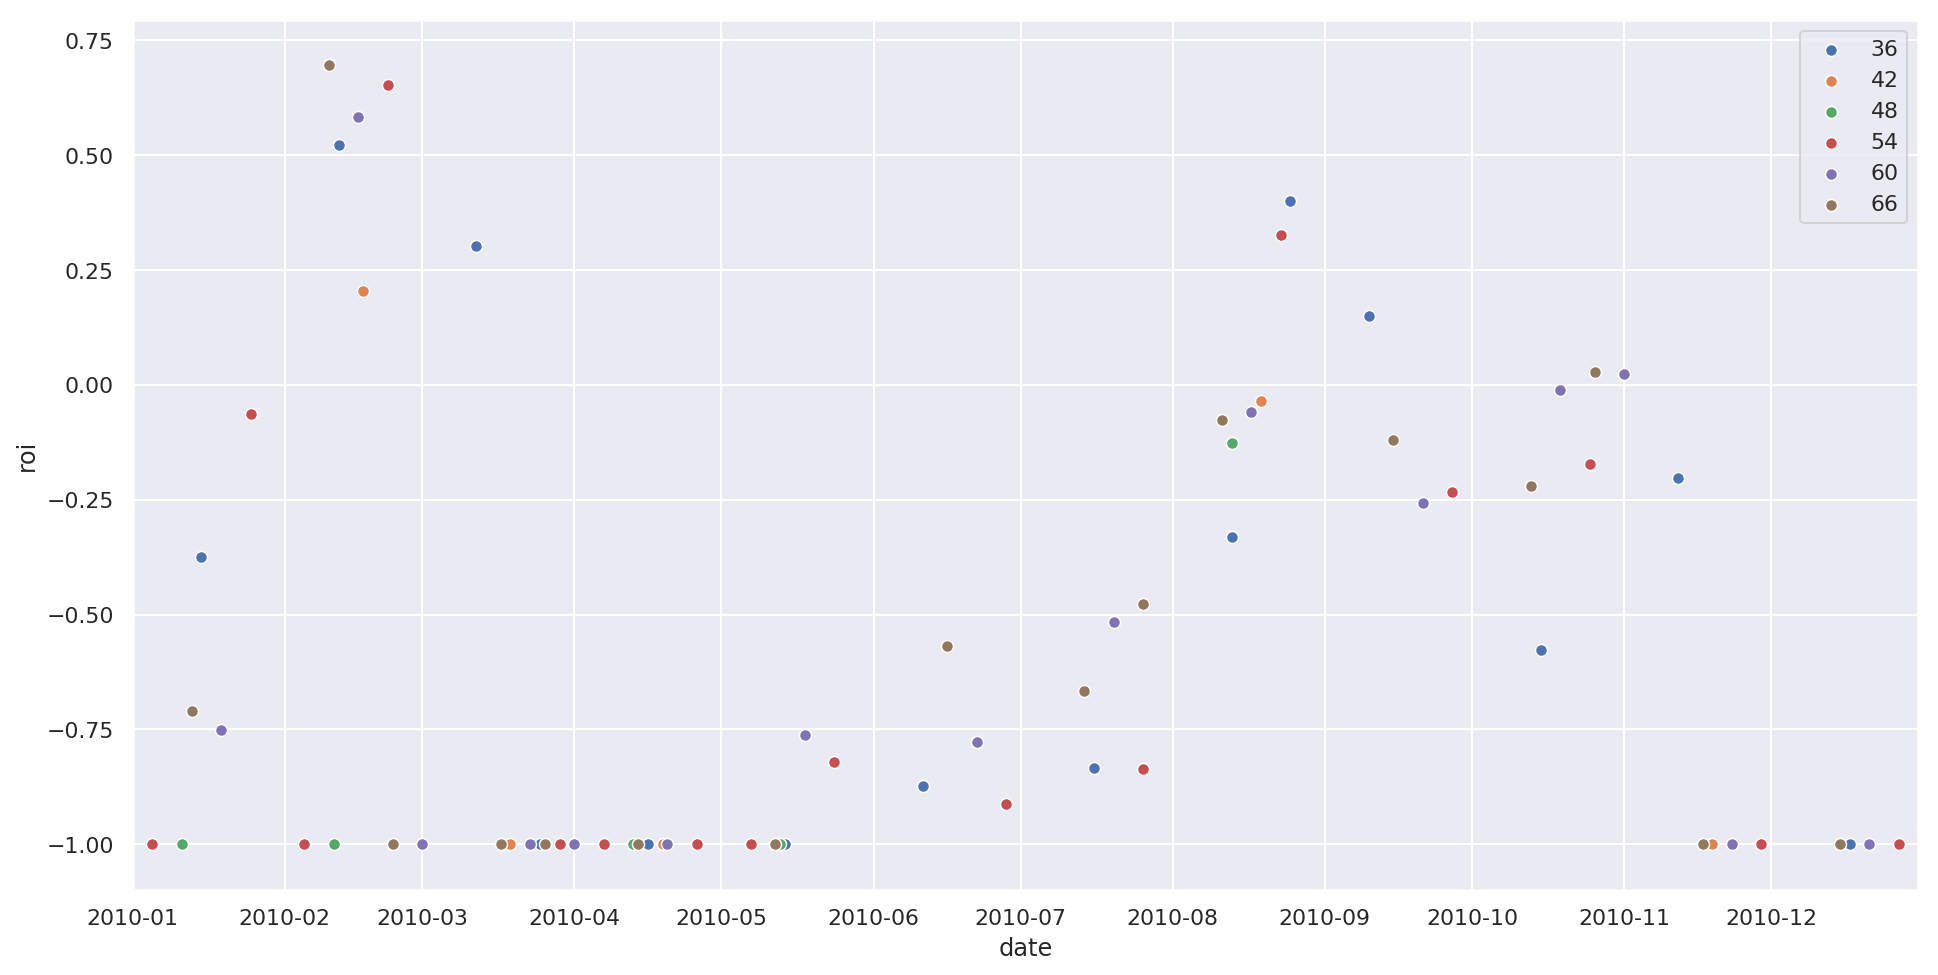

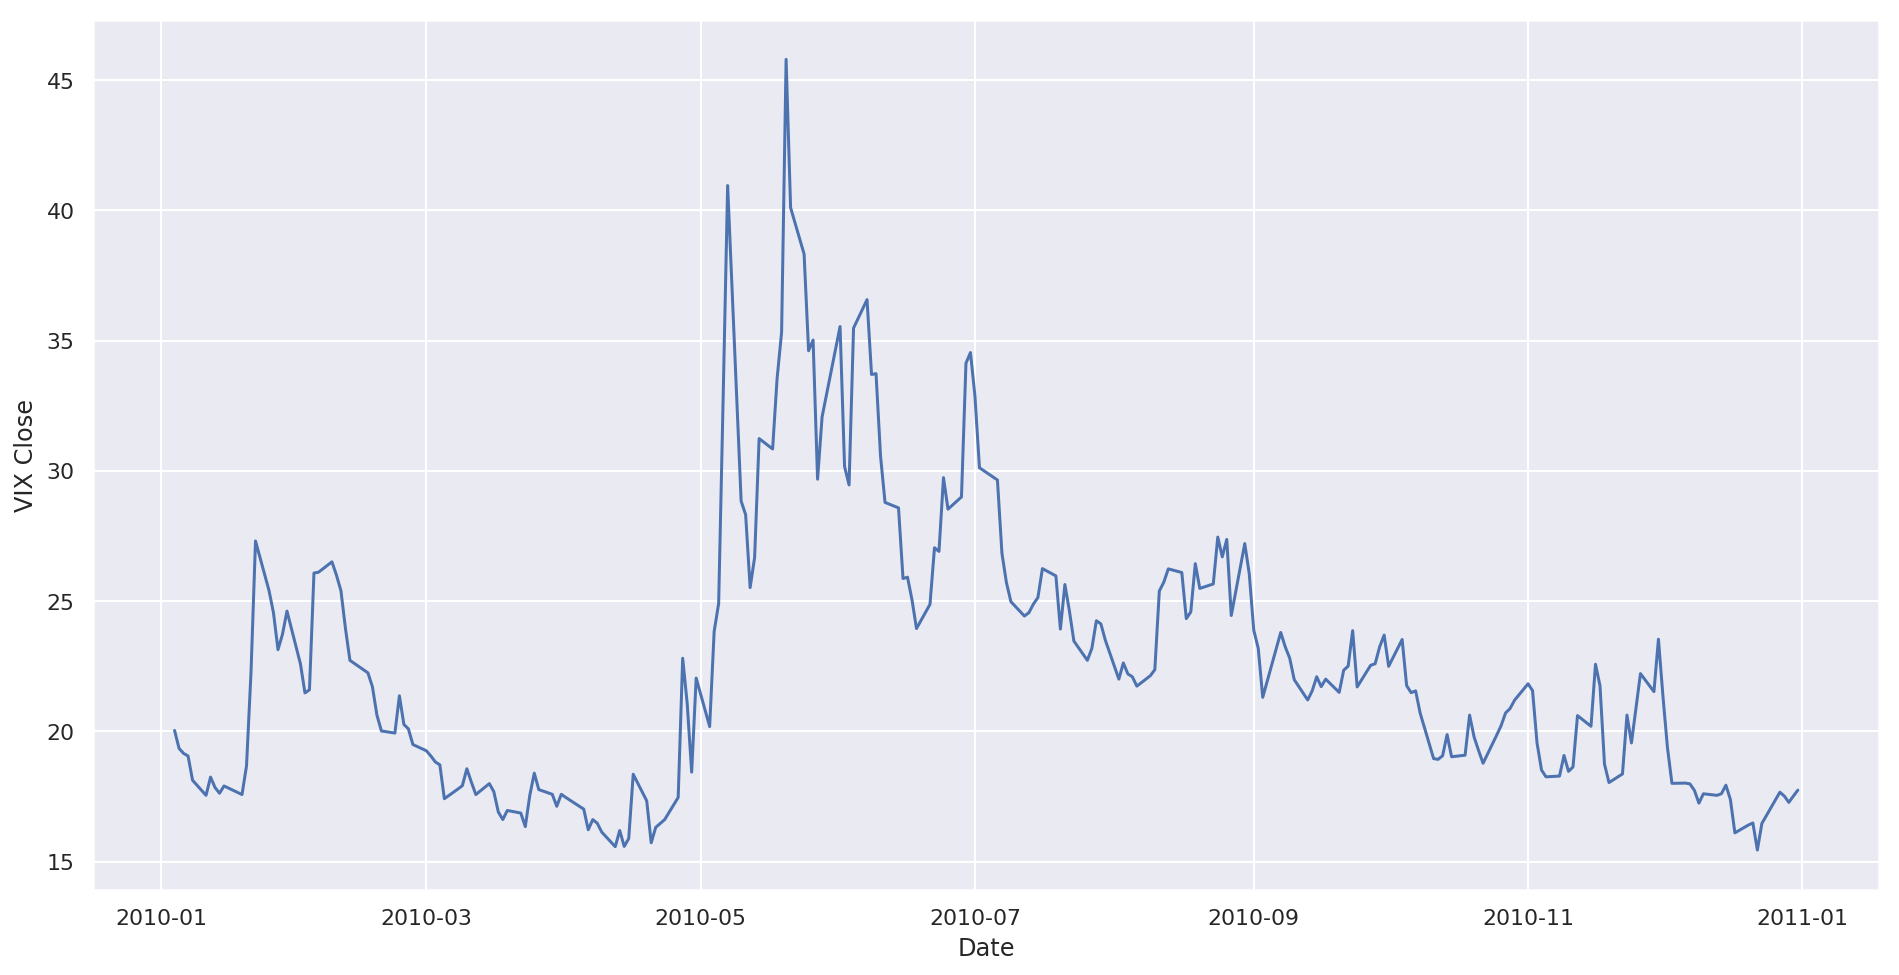

In [36]:
_fig, ax = plt.subplots(figsize=(16,8))
ax.set_xlim([pd.Timestamp(2010, 1, 1), pd.Timestamp(2010, 12, 31)])
for entry_dte in range(36, 71, 6):
    results = straddle(spx_data, entry_dte=entry_dte, tolerance=0)
    sns.scatterplot(x=results.index, y="roi", data=results, ax=ax, label=entry_dte)
    
vix_2010 = vix_data.loc['2010',]
_fig, ax2 = plt.subplots(figsize=(16,8))
sns.lineplot(x=vix_2010.index, y="VIX Close", data=vix_2010)

## Straddle over all data

Now we'll run straddles using all SPX options data from 1990 to 2018.

In [37]:
all_data = pd.read_hdf("../data/options_data_v2.h5", key="/SPX")

Lets see the number of options contracts per day.

In [49]:
daily_options = all_data.groupby("quotedate").size().reset_index(name="count")
daily_options.head()

,quotedate,count
0,1990-01-02,170
1,1990-01-03,170
2,1990-01-04,170
3,1990-01-05,170
4,1990-01-08,170


In [50]:
daily_options.tail()

,quotedate,count
7302,2018-12-24,3630
7303,2018-12-26,3840
7304,2018-12-27,3844
7305,2018-12-28,3844
7306,2018-12-31,3850


Now lets visualize the number of options contracts by _dte_ (days to expiration).

In [71]:
dtes = pd.DataFrame({"year": all_data["quotedate"].dt.year,
                     "dte": (all_data["expiration"] - all_data["quotedate"]).dt.days})

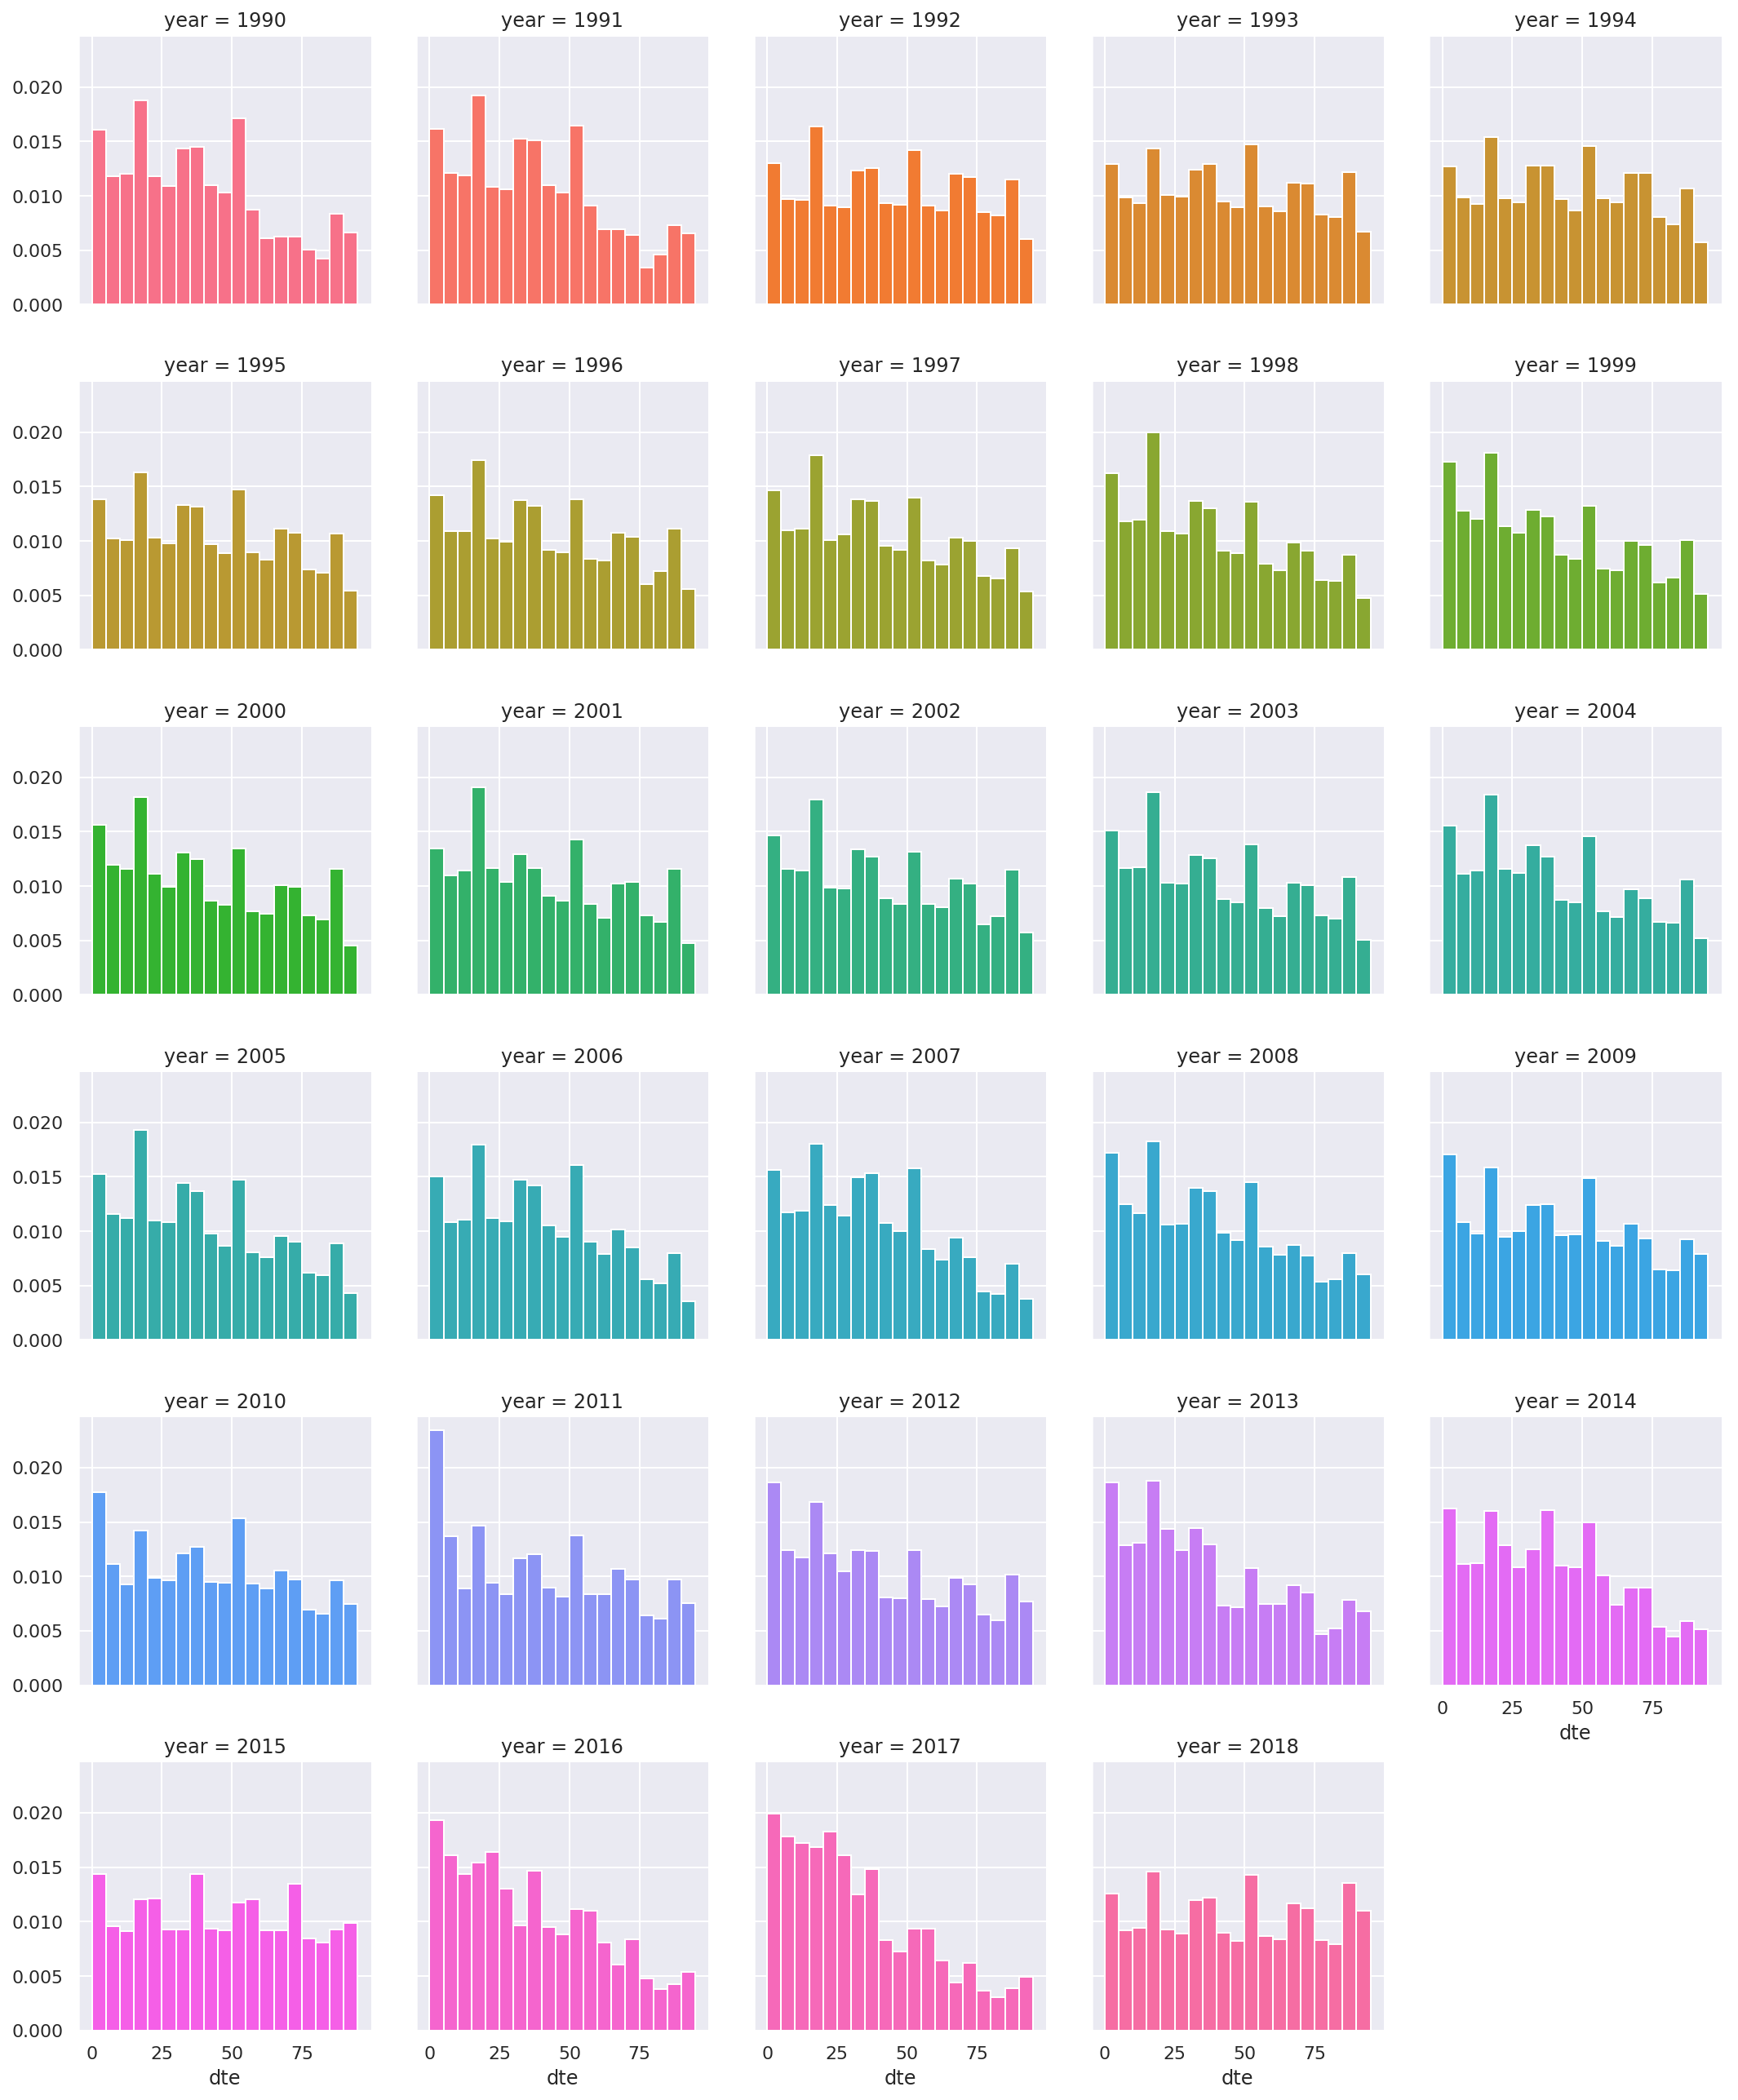

In [70]:
g = sns.FacetGrid(dtes, col="year", col_wrap=5, hue="year")
bins = list(range(0, 100, 5))
g.map(plt.hist, "dte", bins=bins, density=True)

Running a straddle with `tolerance = 0` and `entry_dte = 36`.

In [38]:
results = straddle(all_data, tolerance=0)

In [39]:
results.head(20)

,exit_date,call,call_exit,call_enter,put,put_enter,put_exit,profit,roi,win/loss,total
date,,,,,,,,,,,
1990-01-12,1990-02-15,SPX900217C00340000,100.0,8800.0,SPX900217P00340000,9500.0,5000.0,-13200.0,-0.721311,loss,-13200.0
1990-02-09,1990-03-15,SPX900317C00335000,3500.0,8000.0,SPX900317P00335000,8800.0,400.0,-12900.0,-0.767857,loss,-26100.0
1990-03-16,1990-04-19,SPX900421C00340000,400.0,7600.0,SPX900421P00340000,4900.0,2800.0,-9300.0,-0.744000,loss,-35400.0
1990-05-11,1990-06-14,SPX900616C00350000,13000.0,9900.0,SPX900616P00350000,5800.0,0.0,-2700.0,-0.171975,loss,-38100.0
1990-06-15,1990-07-19,SPX900721C00365000,1200.0,5800.0,SPX900721P00365000,6400.0,900.0,-10100.0,-0.827869,loss,-48200.0
1990-07-13,1990-08-16,SPX900818C00365000,0.0,9200.0,SPX900818P00365000,5900.0,34100.0,19000.0,1.258278,win,-29200.0
1990-08-17,1990-09-20,SPX900922C00330000,0.0,8800.0,SPX900922P00330000,10200.0,18200.0,-800.0,-0.042105,loss,-30000.0
1990-09-14,1990-10-18,SPX901020C00315000,100.0,11400.0,SPX901020P00315000,9400.0,9100.0,-11600.0,-0.557692,loss,-41600.0
1990-10-12,1990-11-15,SPX901117C00300000,17100.0,11200.0,SPX901117P00300000,10500.0,100.0,-4500.0,-0.207373,loss,-46100.0


In [40]:
results.tail()

,exit_date,call,call_exit,call_enter,put,put_enter,put_exit,profit,roi,win/loss,total
date,,,,,,,,,,,
2018-08-17,2018-09-20,SPX180921C02850000,80100.0,32600.0,SPX180921P02850000,31400.0,100.0,16200.0,0.253125,win,-8517450.0
2018-09-14,2018-10-18,SPX181019C02905000,0.0,32500.0,SPX181019P02905000,28700.0,124800.0,63600.0,1.039216,win,-8453850.0
2018-10-12,2018-11-15,SPX181116C02765000,500.0,59900.0,SPX181116P02765000,58400.0,31000.0,-86800.0,-0.733728,loss,-8540650.0
2018-11-16,2018-12-20,SPX181221C02735000,0.0,58000.0,SPX181221P02735000,52000.0,258400.0,148400.0,1.349091,win,-8392250.0
2018-12-14,2019-01-17,SPX190118C02600000,0.0,65100.0,SPX190118P02600000,60500.0,0.0,-125600.0,-1.000000,loss,-8517850.0


In [41]:
results["win/loss"].value_counts()

loss    450
win     192
Name: win/loss, dtype: int64

In [42]:
len(results)

642

We can also slice the data, in this case we are interested in the period 1995 to 2003.

In [44]:
sliced = all_data.query("quotedate>='1995-01-01' & quotedate<='2003-12-31'")

In [45]:
sliced.head()

,underlying,underlying_last,exchange,optionroot,optionext,type,expiration,quotedate,strike,last,bid,ask,volume,openinterest,impliedvol,delta,gamma,theta,vega,optionalias
300448,SPX,459.11,*,SPX950121C00375000,NaN,call,1995-01-21,1995-01-03,375.0,0.0,84.1,85.1,0,0,0.0886,1.0000,0.0000,-0.0648,0.0000,SPX950121C00375000
300449,SPX,459.11,*,SPX950121C00380000,NaN,call,1995-01-21,1995-01-03,380.0,0.0,79.3,80.3,0,0,0.0886,1.0000,0.0000,-0.0657,0.0000,SPX950121C00380000
300450,SPX,459.11,*,SPX950121C00400000,NaN,call,1995-01-21,1995-01-03,400.0,0.0,59.4,60.4,0,2,0.1436,1.0000,0.0000,-0.0691,0.0000,SPX950121C00400000
300451,SPX,459.11,*,SPX950121C00420000,NaN,call,1995-01-21,1995-01-03,420.0,0.0,40.0,41.0,0,319,0.2026,0.9824,0.0021,-0.0965,0.0434,SPX950121C00420000
300452,SPX,459.11,*,SPX950121C00425000,NaN,call,1995-01-21,1995-01-03,425.0,35.0,35.1,36.1,20,20,0.1817,0.9796,0.0027,-0.0976,0.0493,SPX950121C00425000


In [46]:
sliced.tail()

,underlying,underlying_last,exchange,optionroot,optionext,type,expiration,quotedate,strike,last,bid,ask,volume,openinterest,impliedvol,delta,gamma,theta,vega,optionalias
1413752,SPX,1111.92,*,SXG051217P01250000,NaN,put,2005-12-17,2003-12-31,1250.0,0.0,165.5,168.5,0,0,0.1347,-0.6802,0.0016,-14.9229,537.1322,SXG051217P01250000
1413753,SPX,1111.92,*,SXG051217P01300000,NaN,put,2005-12-17,2003-12-31,1300.0,0.0,200.6,203.6,0,0,0.1313,-0.7548,0.0015,-11.4603,465.4420,SXG051217P01300000
1413754,SPX,1111.92,*,SXG051217P01325000,NaN,put,2005-12-17,2003-12-31,1325.0,0.0,219.3,222.3,0,0,0.1301,-0.7871,0.0013,-9.6928,425.6061,SXG051217P01325000
1413755,SPX,1111.92,*,SXG051217P01350000,NaN,put,2005-12-17,2003-12-31,1350.0,0.0,238.7,241.7,0,6,0.1292,-0.8158,0.0012,-7.9588,385.1799,SXG051217P01350000
1413756,SPX,1111.92,*,SXG051217P01400000,NaN,put,2005-12-17,2003-12-31,1400.0,0.0,0.0,0.0,0,8,0.1283,-0.8626,0.0010,-4.7362,307.9436,SXG051217P01400000


Running our default straddle on this period's data.

In [47]:
sliced_results = straddle(sliced, tolerance=0)
sliced_results

,exit_date,call,call_exit,call_enter,put,put_enter,put_exit,profit,roi,win/loss,total
date,,,,,,,,,,,
1995-01-13,1995-02-16,SPX950218C00465000,20100.0,7100.0,SPX950218P00465000,4200.0,0.0,8800.0,0.778761,win,8.800000e+03
1995-02-10,1995-03-16,SPX950318C00480000,15100.0,7400.0,SPX950318P00480000,4200.0,0.0,3500.0,0.301724,win,1.230000e+04
1995-02-23,1995-03-29,SPX950331C00490000,13200.0,4200.0,SPX950331P00490000,6100.0,0.0,2900.0,0.281553,win,1.520000e+04
1995-03-17,1995-04-20,SPX950422C00495000,10100.0,7300.0,SPX950422P00495000,5000.0,0.0,-2200.0,-0.178862,loss,1.300000e+04
1995-05-12,1995-06-15,SPX950617C00525000,12400.0,7400.0,SPX950617P00525000,5300.0,0.0,-300.0,-0.023622,loss,1.270000e+04
1995-05-25,1995-06-28,SPX950630C00530000,0.0,6100.0,SPX950630P00530000,7100.0,200.0,-13000.0,-0.984848,loss,-3.000000e+02
1995-06-16,1995-07-20,SPX950722C00540000,13100.0,7100.0,SPX950722P00540000,5400.0,0.0,600.0,0.048000,win,3.000000e+02
1995-07-14,1995-08-17,SPX950819C00560000,300.0,8200.0,SPX950819P00560000,7200.0,1200.0,-13900.0,-0.902597,loss,-1.360000e+04
1995-08-11,1995-09-14,SPX950916C00555000,28400.0,8400.0,SPX950916P00555000,6400.0,0.0,13600.0,0.918919,win,5.456968e-12


In [48]:
sliced_results["win/loss"].value_counts()

loss    74
win     36
Name: win/loss, dtype: int64

Now we try the straddle entering 7 days before expiration.

In [72]:
week_dte = straddle(all_data, entry_dte=7, tolerance=0)
len(week_dte)

631

In [73]:
week_dte.head()

,exit_date,call,call_exit,call_enter,put,put_enter,put_exit,profit,roi,win/loss,total
date,,,,,,,,,,,
1993-03-24,1993-03-29,SPX930331C00450000,2000.0,1200.0,SPX930331P00450000,3400.0,1100.0,-1500.0,-0.326087,loss,-1.500000e+03
1993-06-23,1993-06-28,SPX930630C00440000,10300.0,6000.0,SPX930630P00440000,1400.0,0.0,2900.0,0.391892,win,1.400000e+03
1993-09-23,1993-09-28,SPX930930C00460000,3000.0,1400.0,SPX930930P00460000,3400.0,400.0,-1400.0,-0.291667,loss,2.273737e-13
1994-03-24,1994-03-29,SPX940331C00460000,200.0,9200.0,SPX940331P00460000,1000.0,7400.0,-2600.0,-0.254902,loss,-2.600000e+03
1994-06-23,1994-06-28,SPX940630C00470000,0.0,100.0,SPX940630P00470000,19900.0,23800.0,3800.0,0.190000,win,1.200000e+03


Lets plot the profits from this strategy.

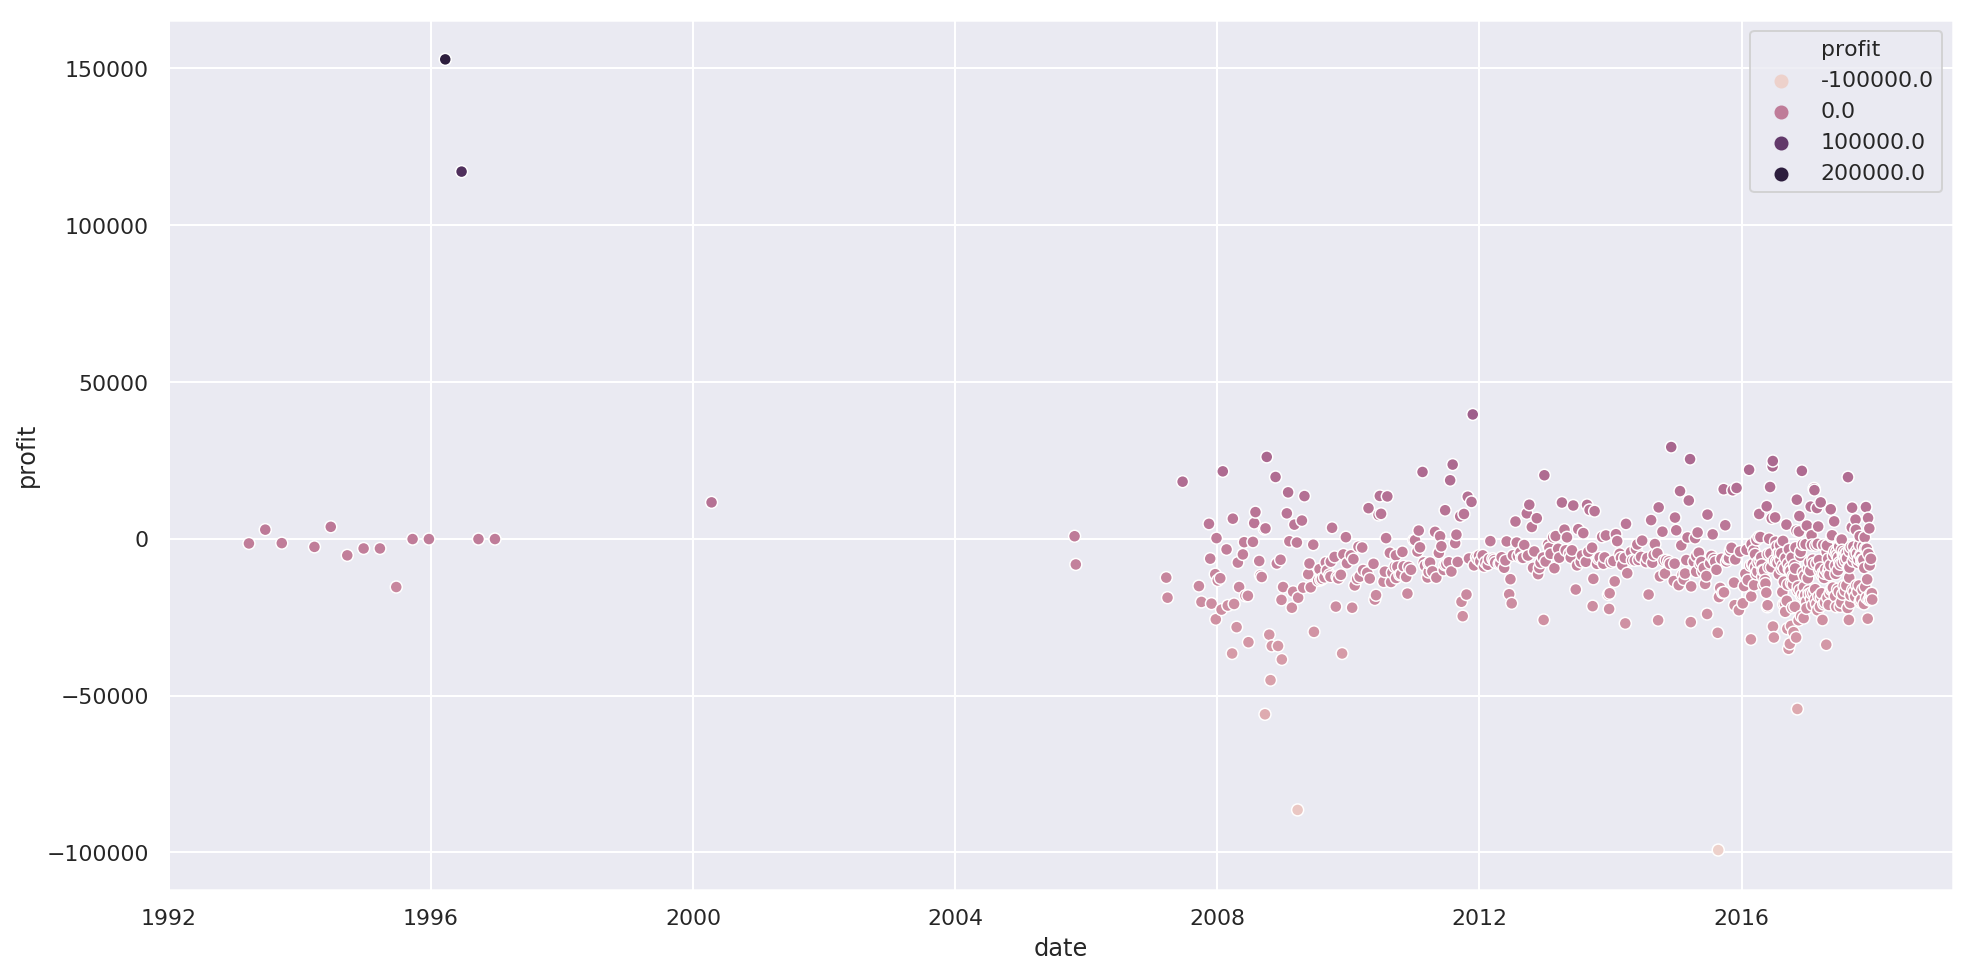

In [75]:
_fig, ax = plt.subplots(figsize=(16,8))
sns.scatterplot(x=week_dte.index, y="profit", hue="profit", data=week_dte, ax=ax)

### Testing different tolerances

With our tolerance parameter we can be more flexible in our choice to enter a straddle. The strategy enters a position in the range `entry_dte - entry_dte * tolerance` to `entry_dte + entry_dte * tolerance`.  
This flexibility increases the number of trades we execute.

To compare, lets count the number of straddles we execute using `tolerance = 0` and `entry_dte = 60`

In [76]:
strict_straddle = straddle(all_data, entry_dte=60, tolerance=0)

In [77]:
len(strict_straddle)

493

Now lets try setting `tolerance = 0.1`

In [78]:
tolerance_straddle = straddle(all_data, entry_dte=60, tolerance=0.1)

In [79]:
len(tolerance_straddle)

3826

Lets plot the profits.

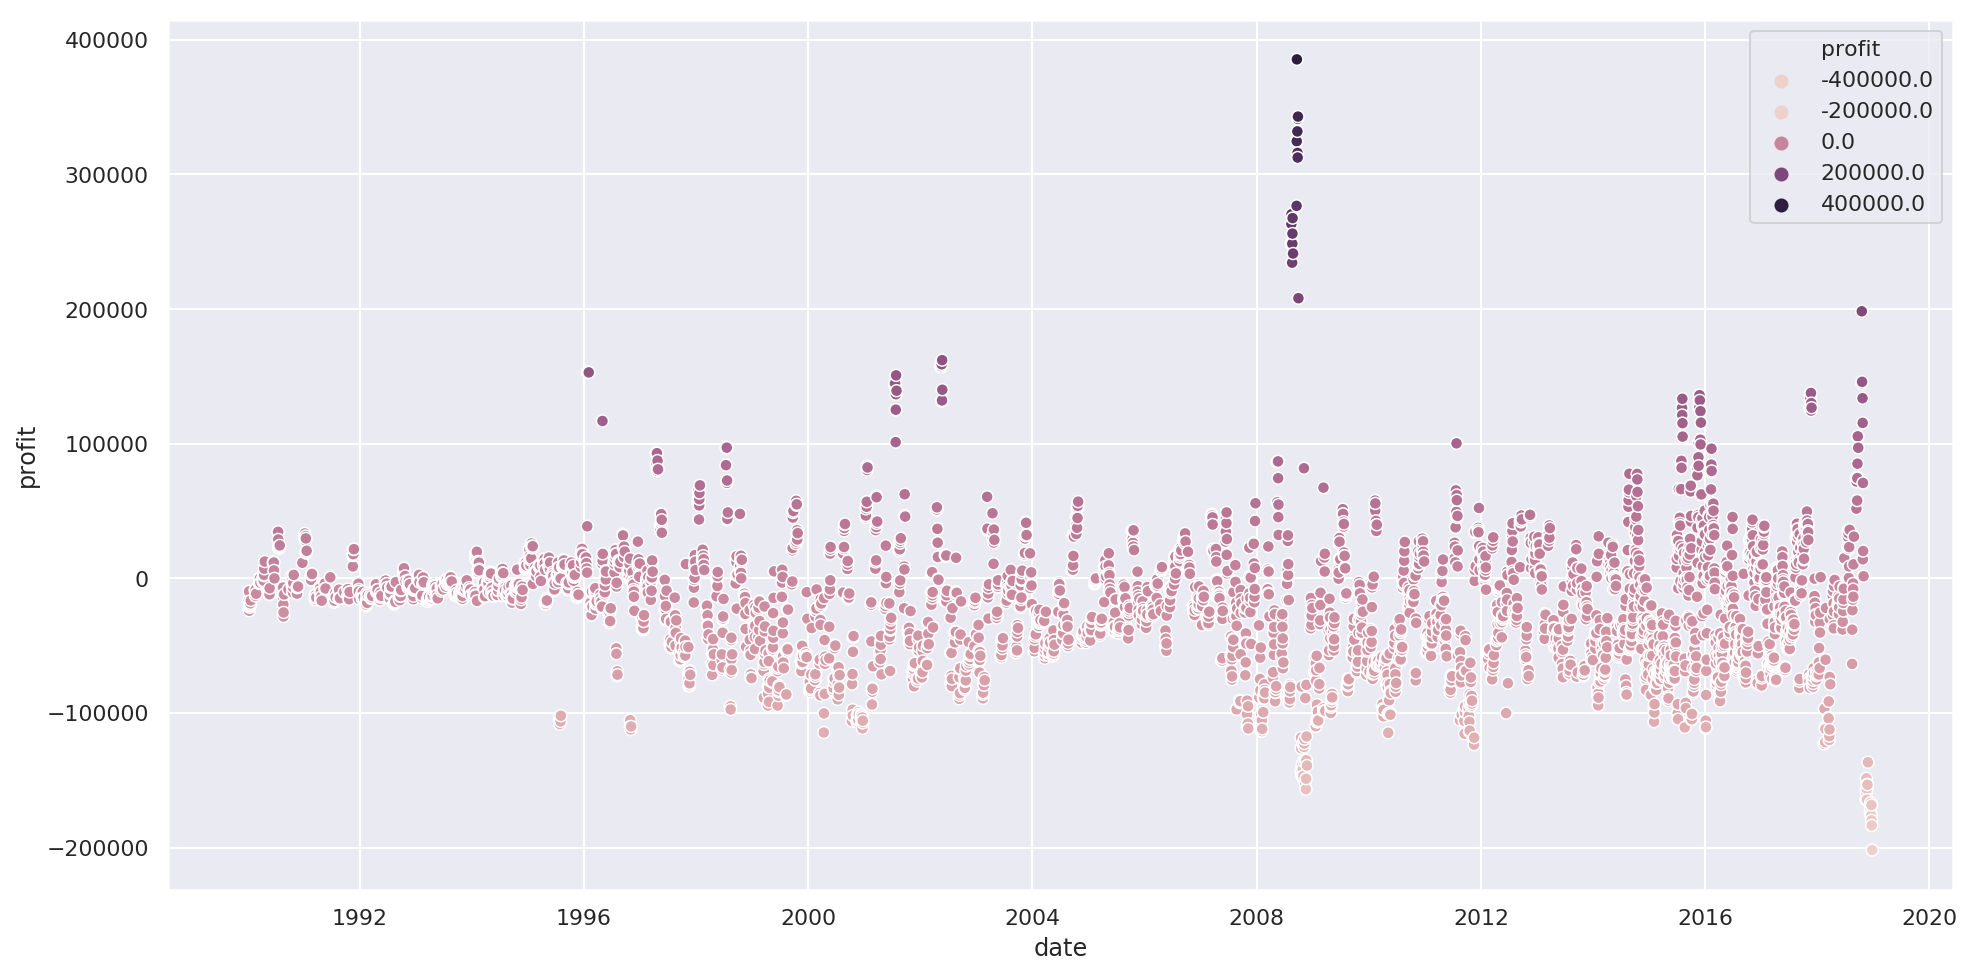

In [80]:
_fig, ax = plt.subplots(figsize=(16,8))
sns.scatterplot(x=tolerance_straddle.index, y="profit", hue="profit", data=tolerance_straddle, ax=ax)